<a href="https://colab.research.google.com/github/Danial-sb/Graph_Level_Prediction/blob/main/Graph_Level_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### In this colab, we do graph level prediction for MUTAG dataset. In the part of training the GNN, first we embed the nodes via message passing. second, we aggregate node embeddings into a graph embedding, and finally, we train a classifier on the graph embeddings.

### **What is MUTAG dataset?**

MUTAG is a collection of nitroaromatic compounds and the goal is to predict their mutagenicity on Salmonella typhimurium. Input graphs are used to represent chemical compounds, where vertices stand for atoms and are labeled by the atom type (represented by one-hot encoding), while edges between vertices represent bonds between the corresponding atoms. It includes 188 samples of chemical compounds with 7 discrete node labels.

##### https://paperswithcode.com/dataset/mutag

In [2]:
import torch
print(torch.__version__)

1.12.1+cu113


In [3]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 8.9 MB 16.6 MB/s 
     |████████████████████████████████| 3.5 MB 14.7 MB/s 
     |████████████████████████████████| 280 kB 15.5 MB/s 


In [4]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import GraphConv
import torchvision.transforms as T
from torch.nn import BatchNorm1d

In [5]:
dataset = TUDataset('/content/sample_data', 'MUTAG')

print(dataset)
print(f"Number of the graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

Extracting /content/sample_data/MUTAG/MUTAG.zip
Processing...


MUTAG(188)
Number of the graphs: 188
Number of features: 7
Number of classes: 2


Done!


In [6]:
data = dataset[0]

print(data)
print(f"Number of nodes in the first graph: {data.num_nodes}")
print(f"Number of features in the first graph: {data.num_features}")
print(f"Number of edges in the first graph: {data.num_edges}")
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes in the first graph: 17
Number of features in the first graph: 7
Number of edges in the first graph: 38
Average node degree: 2.24


In [7]:
train_dataset = dataset[:140]
test_dataset = dataset[140:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 140
Number of test graphs: 48


In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
# batch maps each node to its respective graph in the batch
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2562], x=[1160, 7], edge_attr=[2562, 4], y=[64], batch=[1160], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2534], x=[1144, 7], edge_attr=[2534, 4], y=[64], batch=[1144], ptr=[65])

Step 3:
Number of graphs in the current batch: 12
DataBatch(edge_index=[2, 524], x=[234, 7], edge_attr=[524, 4], y=[12], batch=[234], ptr=[13])



In this part, we do the message passing between nodes through 3 GCN layers. Then, we need to aggregate the embeddings to perform graph level prediction, and in this part we use average pooling.

In [11]:
class GCN(torch.nn.Module):
  def __init__(self, input_channels, hidden_channels, output_channels):
     super(GCN, self).__init__()

     self.conv1 = GCNConv(input_channels, hidden_channels)
     self.bn1 = BatchNorm1d(hidden_channels)
     self.conv2 = GCNConv(hidden_channels, hidden_channels)
     self.bn2 = BatchNorm1d(hidden_channels)
     self.conv3 = GCNConv(hidden_channels, hidden_channels)
     self.lin = Linear(hidden_channels, output_channels)

  def forward(self, x, edge_index, batch):
    x = self.conv1(x, edge_index)
    x = F.relu(self.bn1(x))
    x = self.conv2(x, edge_index)
    x = F.relu(self.bn2(x))
    x = self.conv3(x, edge_index)

    # Average pooling (Readout layer)
    x = global_mean_pool(x, batch)

    x = F.dropout(x, 0.2, training = self.training)
    x = self.lin(x)

    return x

model = GCN(dataset.num_features, 64, dataset.num_classes)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(64, 64)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [12]:
model = GCN(dataset.num_features, 64, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
  model.train()
  correct = 0
  loss_all = 0
  total_examples = 0
  for data in train_loader:
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.batch)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    loss_all += loss.item() * data.num_nodes
    total_examples += data.num_nodes
    pred = out.argmax(dim=1)
    correct += int((pred == data.y).sum())
  return loss_all / total_examples, (correct / len(train_dataset))

@torch.no_grad()
def test():
     model.eval()
     correct = 0
     for data in test_loader:
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)
         correct += int((pred == data.y).sum())
     return correct / len(test_dataset)

loss_all = []
train_acc = []
test_acc = []
for epoch in range(1, 201):
    loss, acc = train()
    loss_all.append(loss)
    train_acc.append(acc)
    t_acc = test()
    test_acc.append(t_acc)
    print(f'Epoch: {epoch}, Train Acc: {acc:.4f}, Loss: {loss:.4f}, Test Acc: {t_acc:.4f}')


Epoch: 1, Train Acc: 0.4643, Loss: 0.7862, Test Acc: 0.6250
Epoch: 2, Train Acc: 0.7571, Loss: 0.5311, Test Acc: 0.6250
Epoch: 3, Train Acc: 0.7643, Loss: 0.5075, Test Acc: 0.6250
Epoch: 4, Train Acc: 0.7786, Loss: 0.5082, Test Acc: 0.6250
Epoch: 5, Train Acc: 0.7714, Loss: 0.4986, Test Acc: 0.6250
Epoch: 6, Train Acc: 0.7643, Loss: 0.4831, Test Acc: 0.6250
Epoch: 7, Train Acc: 0.7857, Loss: 0.5038, Test Acc: 0.6250
Epoch: 8, Train Acc: 0.7857, Loss: 0.4894, Test Acc: 0.6250
Epoch: 9, Train Acc: 0.7714, Loss: 0.5013, Test Acc: 0.6250
Epoch: 10, Train Acc: 0.7857, Loss: 0.5015, Test Acc: 0.6458
Epoch: 11, Train Acc: 0.7929, Loss: 0.4901, Test Acc: 0.6250
Epoch: 12, Train Acc: 0.7786, Loss: 0.4966, Test Acc: 0.6458
Epoch: 13, Train Acc: 0.8000, Loss: 0.4823, Test Acc: 0.6667
Epoch: 14, Train Acc: 0.7714, Loss: 0.4738, Test Acc: 0.6667
Epoch: 15, Train Acc: 0.7857, Loss: 0.4697, Test Acc: 0.6458
Epoch: 16, Train Acc: 0.7786, Loss: 0.4692, Test Acc: 0.6250
Epoch: 17, Train Acc: 0.7857, Los

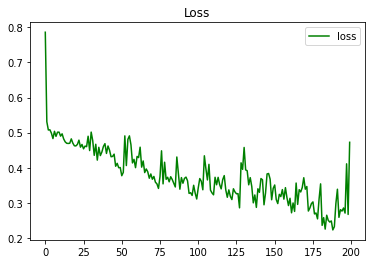

In [13]:
import matplotlib.pyplot as plt
plt.plot(loss_all, c= 'green', label = 'loss')
plt.legend(loc = 1)
plt.title('Loss')
plt.show()

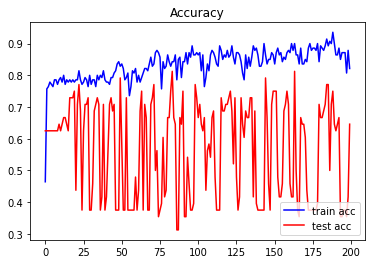

In [19]:
plt.plot(train_acc, c= 'blue', label = 'train acc')
plt.plot(test_acc, c = 'red', label = 'test acc')
plt.legend(loc = 4)
plt.title('Accuracy')
plt.show()
# the fluctuations can be due to the size of our test data

Neighborhood normalization decreases the expressivity of GNNs in distinguishing certain graph structures. An alternative formulation gets rid of neighborhood normalization and adds a skip-connection to the GNN layer in order to preserve central node information.

In the next model, we will implenent make use of GraphConv.

##### For more infomration, refer to this paper: [Morris et al. (2018)](https://arxiv.org/abs/1810.02244)

In [15]:
class GNN(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super(GNN, self).__init__()
        self.conv1 = GraphConv(input_channels, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, output_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(self.bn1(x))
        x = self.conv2(x, edge_index)
        x = F.relu(self.bn2(x))
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model2 = GNN(dataset.num_features,64, dataset.num_classes)
print(model2)

GNN(
  (conv1): GraphConv(7, 64)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GraphConv(64, 64)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [16]:
model2 = GNN(dataset.num_features, 64, dataset.num_classes)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
  model2.train()
  correct = 0
  loss_all = 0
  total_examples = 0
  for data in train_loader:
    optimizer.zero_grad()
    out = model2(data.x, data.edge_index, data.batch)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    loss_all += loss.item() * data.num_nodes
    total_examples += data.num_nodes
    pred = out.argmax(dim=1)
    correct += int((pred == data.y).sum())
  return (loss_all / total_examples), (correct / len(train_dataset))

@torch.no_grad()
def test():
     model2.eval()
     correct = 0
     for data in test_loader:
         out = model2(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)
         correct += int((pred == data.y).sum())
     return correct / len(test_dataset)

loss_all_gnn = []
train_acc_gnn = []
test_acc_gnn = []
for epoch in range(1, 201):
    loss, acc = train()
    loss_all_gnn.append(loss)
    train_acc_gnn.append(acc)
    t_acc = test()
    test_acc_gnn.append(t_acc)
    print(f'Epoch: {epoch}, Train Acc: {acc:.4f}, Loss: {loss:.4f}, Test Acc: {t_acc:.4f}')


Epoch: 1, Train Acc: 0.4786, Loss: 1.0152, Test Acc: 0.6250
Epoch: 2, Train Acc: 0.6786, Loss: 1.1989, Test Acc: 0.6250
Epoch: 3, Train Acc: 0.6857, Loss: 0.6347, Test Acc: 0.7500
Epoch: 4, Train Acc: 0.5714, Loss: 0.7218, Test Acc: 0.6250
Epoch: 5, Train Acc: 0.8286, Loss: 0.3780, Test Acc: 0.6250
Epoch: 6, Train Acc: 0.7500, Loss: 0.4565, Test Acc: 0.6250
Epoch: 7, Train Acc: 0.7857, Loss: 0.4288, Test Acc: 0.7500
Epoch: 8, Train Acc: 0.8071, Loss: 0.3690, Test Acc: 0.7083
Epoch: 9, Train Acc: 0.8286, Loss: 0.3554, Test Acc: 0.6667
Epoch: 10, Train Acc: 0.8214, Loss: 0.3752, Test Acc: 0.5000
Epoch: 11, Train Acc: 0.8500, Loss: 0.3246, Test Acc: 0.7083
Epoch: 12, Train Acc: 0.8714, Loss: 0.4007, Test Acc: 0.6042
Epoch: 13, Train Acc: 0.8786, Loss: 0.2890, Test Acc: 0.6667
Epoch: 14, Train Acc: 0.8714, Loss: 0.2628, Test Acc: 0.7292
Epoch: 15, Train Acc: 0.8500, Loss: 0.2675, Test Acc: 0.7083
Epoch: 16, Train Acc: 0.9071, Loss: 0.2412, Test Acc: 0.7292
Epoch: 17, Train Acc: 0.9214, Los

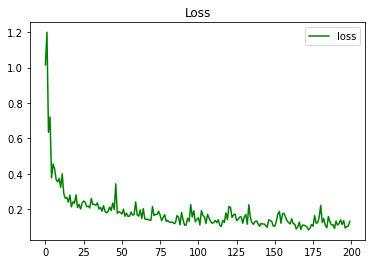

In [17]:
import matplotlib.pyplot as plt
plt.plot(loss_all_gnn, c= 'green', label = 'loss')
plt.legend(loc = 1)
plt.title("Loss")
plt.show()

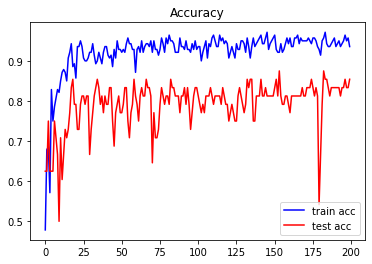

In [20]:
plt.plot(train_acc_gnn, c = 'blue', label = 'train acc')
plt.plot(test_acc_gnn, c = 'red', label = 'test acc')
plt.legend(loc = 4)
plt.title('Accuracy')
plt.show()